## Download CAM set from Audit Analytics data from WRDS
* For Large-accelerated filers (LAFs): CAM is effective for audits of fiscal years ending on or after <b>June 30, 2019</b>.
* For the others: CAM is effective for audits of fiscal years ending on or after <b>Dec. 15, 2020</b>.
* Audit Analytics CAM data doesn't include date information. It can be obtained from Audit Opinion data.
* See for the regulatory details: https://pcaobus.org/oversight/standards/auditing-standards/details/AS3101


-------------------------

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import wrds
import matplotlib.pyplot as plt
pd.options.display.max_columns=200

-------------

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


### Get variable list

In [3]:
df= conn.get_table(library='audit', table='feed78_critical_audit_matter')
print(df.shape)
df.head(2)

(21146, 11)


,description,response,title,critical_audit_matter_key,reference,critical_audit_matter_topic_fkey,topic_name,audit_opinion_fkey,auditor_fkey,company_fkey,best_edgar_ticker
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR


In [4]:
df.rename(columns={'description':'desc',
                  'response':'resp',
                  'critical_audit_matter_key':'cam_key',
                  'reference':'ref',
                  'critical_audit_matter_topic_fkey':'cam_topic_key',
                  'audit_opinion_fkey':'audit_op_key',
                  'auditor_fkey':'afk',
                  'company_fkey':'cik',
                  'best_edgar_ticker':'tic'}, inplace= True)
df.head(2)

,desc,resp,title,cam_key,ref,cam_topic_key,topic_name,audit_op_key,afk,cik,tic
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR


In [5]:
pd.DataFrame(df.nunique()).rename(columns={0:'Unique N'})

,Unique N
desc,18933
resp,17788
title,10252
cam_key,21146
ref,2733
cam_topic_key,56
topic_name,56
audit_op_key,14168
afk,250
cik,5667


----------------------

### Distribution of CAM topics

In [6]:
df_dist= df.groupby('topic_name').count()['cam_key'].sort_values(ascending=False).reset_index()
df_dist

,topic_name,cam_key
0,Revenue from customer contracts,2536
1,Business combinations,2118
2,Goodwill,1925
3,Allowance for credit losses,1354
4,Other contingent liabilities,895
5,Other investments,756
6,Other debt,732
7,Inventory,724
8,Long-lived assets,686
9,Other intangible assets,637


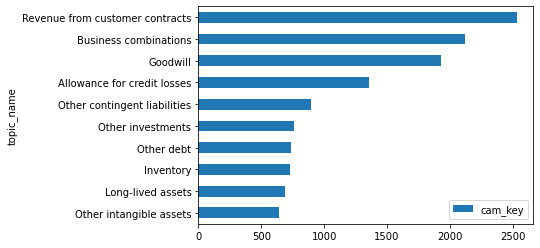

In [7]:
df_dist_top10= df_dist.head(10).sort_values('cam_key', ascending= True)
df_dist_top10.plot(kind='barh', x= 'topic_name', y= 'cam_key')
plt.show()

In [8]:
df.head(2)

,desc,resp,title,cam_key,ref,cam_topic_key,topic_name,audit_op_key,afk,cik,tic
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR


### How many CAMs for each audit report?

In [9]:
df_cam_n= pd.DataFrame(df.groupby('audit_op_key').agg({'cam_topic_key':'count'}).value_counts()).reset_index().rename(columns={'cam_topic_key':'cam_N', 0:'N'})
df_cam_n['cam_N']= df_cam_n['cam_N'].astype('str')
df_cam_n

,cam_N,N
0,1,8975
1,2,3798
2,3,1073
3,4,270
4,5,39
5,6,10
6,7,3


In [10]:
df_cam_n.cam_N= df_cam_n.cam_N.astype('str')
df_cam_n.sort_values('cam_N', ascending= False, inplace= True)

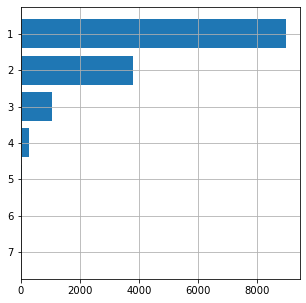

In [11]:
fig=plt.figure(figsize=(5,5))
plt.grid()
plt.barh(df_cam_n.cam_N, df_cam_n.N)
plt.show()

In [12]:
# df_cam_n.to_csv('data\cam.csv')

-----------

### Close connection

In [13]:
conn.close()

-------------